# Causal Learning

## Imports

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from causalnex.structure.notears import from_pandas
from IPython.display import Image
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure, NODE_STYLE, EDGE_STYLE

In [2]:
sns.set()
%matplotlib inline
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option("expand_frame_repr", False)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
sys.path.append(os.path.abspath(os.path.join('../scripts')))

In [4]:
from file_handler import FileHandler
import vis_seaborn as vs
from eda_helper import Helper

In [5]:
helper = Helper()

## Data reading

In [18]:
fh = FileHandler()
df = fh.read_csv("../data/data.csv")
df.head(5)


INFO:file_handler:Csv file read from ../data/data.csv.


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.00,0.12,0.23,0.28,0.15,0.24,0.08,0.85,0.91,5.98,86.20,0.01,0.05,0.05,0.02,0.03,0.01,25.38,17.33,184.60,1937.05,0.16,0.63,0.71,0.27,0.42,0.12
1,842517,M,20.57,17.77,132.90,1326.00,0.08,0.08,0.09,0.07,0.18,0.06,0.54,0.73,3.40,74.08,0.01,0.01,0.02,0.01,0.01,0.00,24.99,23.41,158.80,1937.05,0.12,0.19,0.24,0.19,0.28,0.09
2,84300903,M,19.69,21.25,130.00,1203.00,0.11,0.16,0.20,0.13,0.21,0.06,0.75,0.79,4.58,86.20,0.01,0.04,0.04,0.02,0.02,0.00,23.57,25.53,152.50,1709.00,0.14,0.42,0.45,0.24,0.36,0.09
3,84348301,M,11.42,20.38,77.58,386.10,0.13,0.23,0.24,0.11,0.25,0.08,0.50,1.16,3.44,27.23,0.01,0.06,0.06,0.02,0.04,0.01,14.91,26.50,98.87,567.70,0.19,0.63,0.69,0.26,0.42,0.12
4,84358402,M,20.29,14.34,135.10,1297.00,0.10,0.13,0.20,0.10,0.18,0.06,0.76,0.78,5.44,86.20,0.01,0.02,0.06,0.02,0.02,0.01,22.54,16.67,152.20,1575.00,0.14,0.20,0.40,0.16,0.24,0.08


In [35]:
y = df['diagnosis']
x = df[['perimeter_worst',
        'concavity_worst',
        'concave points_worst',
        'area_worst',
        'radius_se',
        'symmetry_worst',
        'smoothness_worst',
        'texture_mean',
        'concavity_mean']]


In [37]:
le = LabelEncoder()
x = helper.custome_normalizer(x)
x['diagnosis'] = le.fit_transform(y)

In [38]:
%%time
sm = from_pandas(x)

CPU times: user 7.3 s, sys: 129 ms, total: 7.42 s
Wall time: 4.46 s


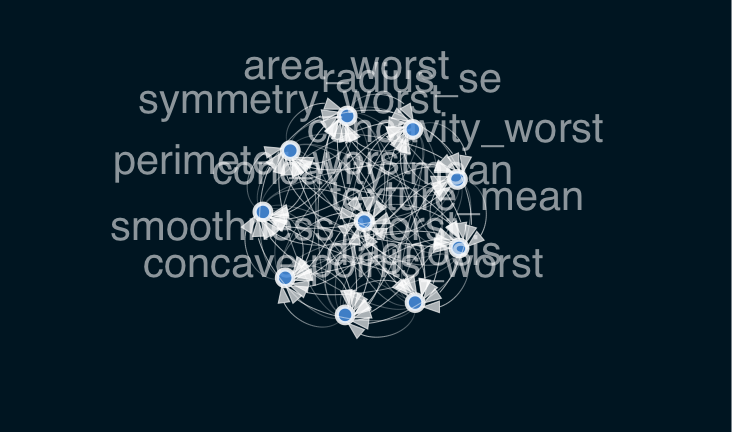

In [39]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

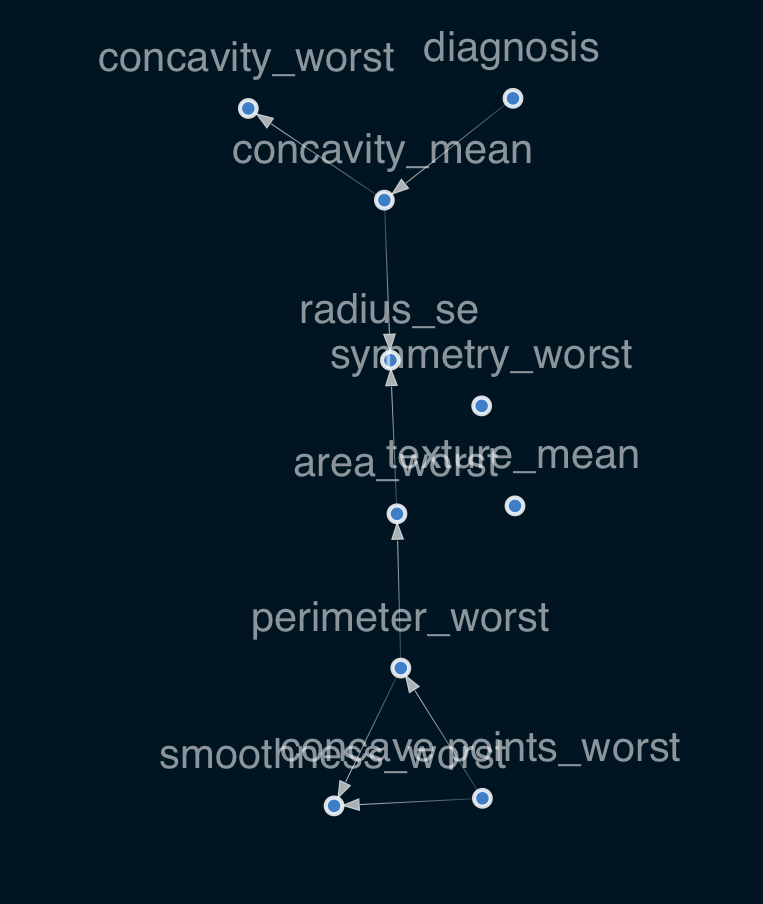

In [40]:
sm.remove_edges_below_threshold(0.8)
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [41]:
sm.remove_edges_below_threshold(0.8)

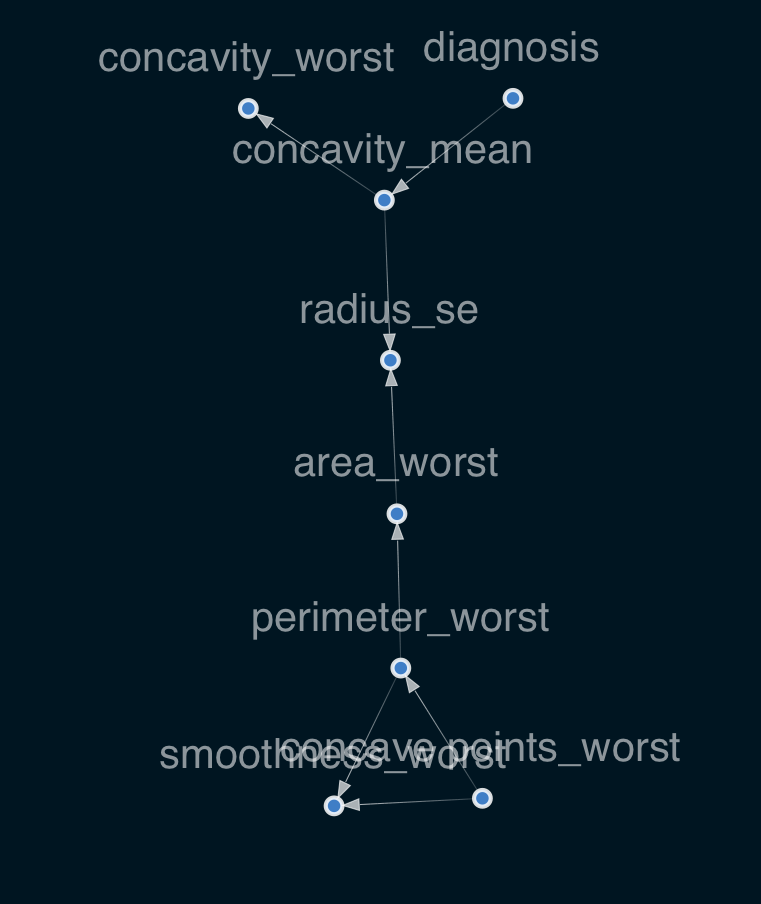

In [42]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [34]:
%%time
sm = from_pandas_lasso(df, tabu_parent_nodes=[
                       'diagnosis'], w_threshold=0.8, beta=0.8)

TypeError: from_pandas() got an unexpected keyword argument 'beta'

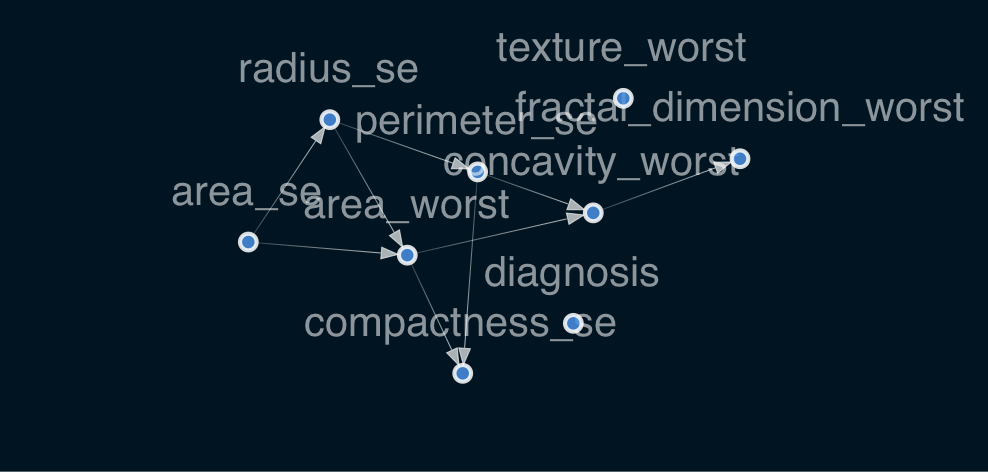

In [30]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

In [31]:
sm.remove_edges_below_threshold(0.8)

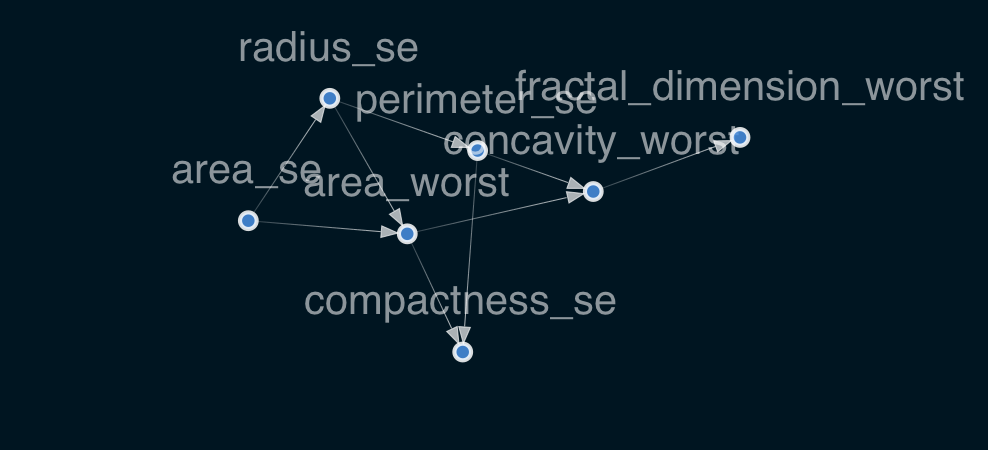

In [33]:
sm = sm.get_largest_subgraph()
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))

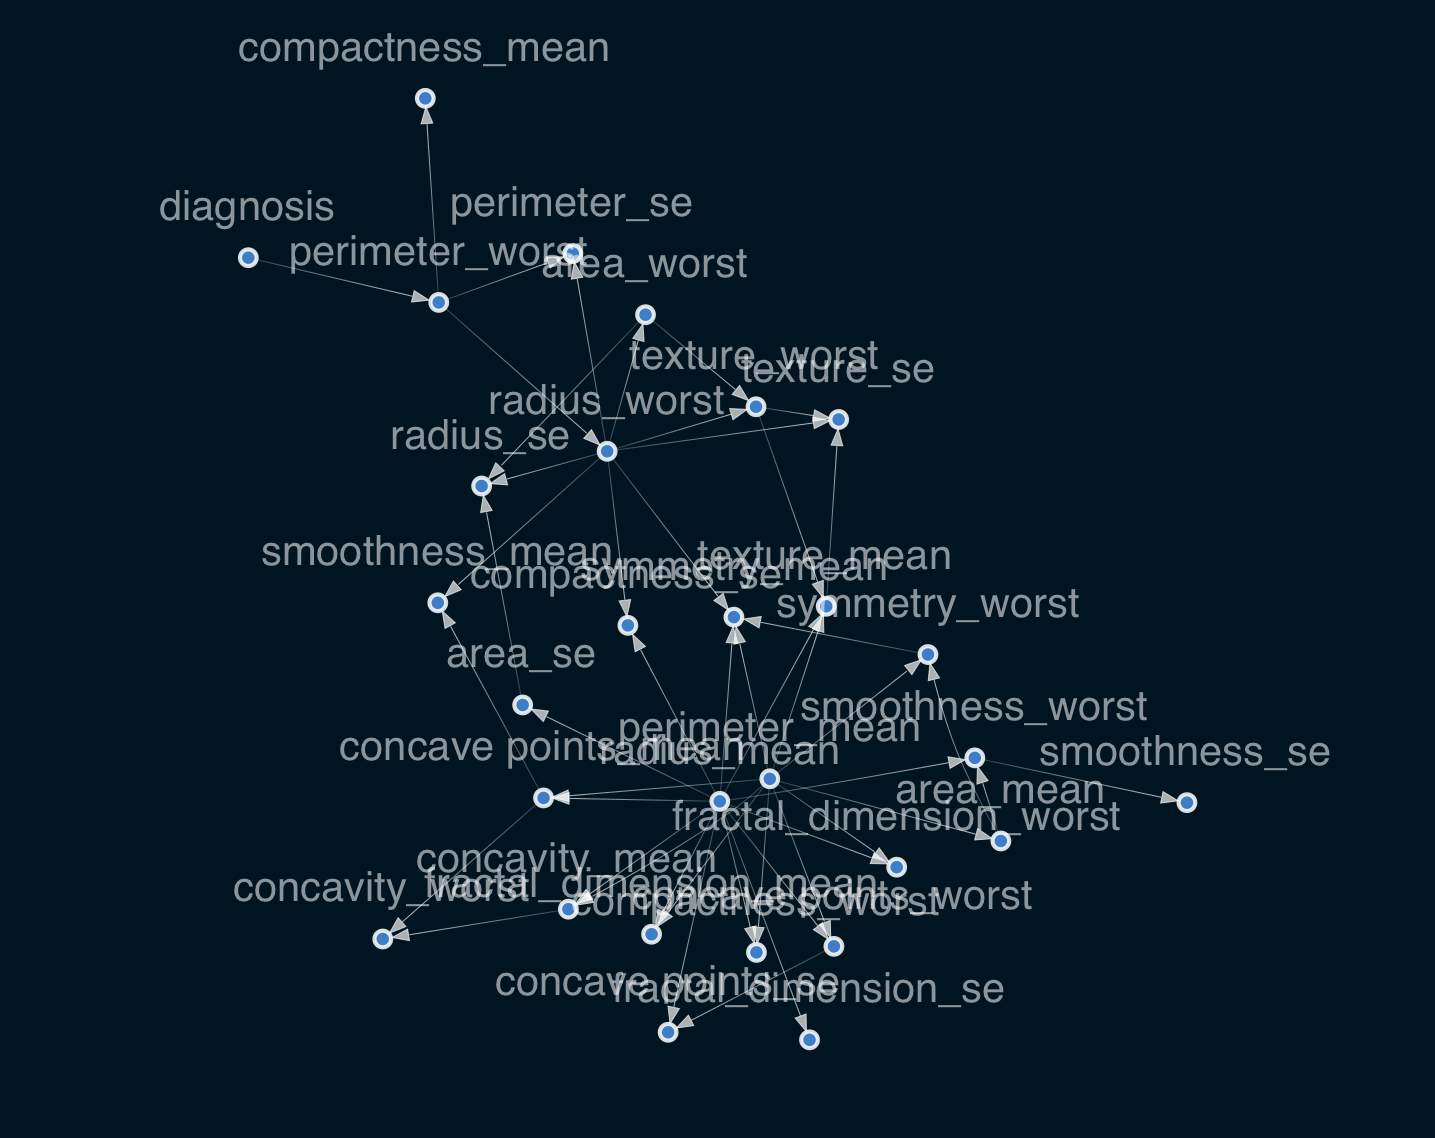

In [45]:

viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))


In [47]:
from causalnex.structure import StructureModel
sm = StructureModel()

In [48]:
sm.add_edges_from([
    ("radius_mean", "perimeter_mean"),
    ("radius_mean", "area_mean"),
    ("radius_mean", "smoothness_mean"),
    ("area_mean", "compactness_mean"),
    ("perimeter_mean", "compactness_mean"),
    ("concave points_mean", "concavity_mean"),
    ("smoothness_mean", "diagnosis"),
    ("concave points_mean", "diagnosis"),
    ("concavity_mean", "diagnosis"),
    ("compactness_mean", "diagnosis"),
    ("perimeter_mean", "diagnosis"),
    ("area_mean", "diagnosis"),
    ("symmetry_mean", "diagnosis"),
    ("fractal_dimension_mean", "diagnosis"),
    ("texture_mean", "diagnosis")
])


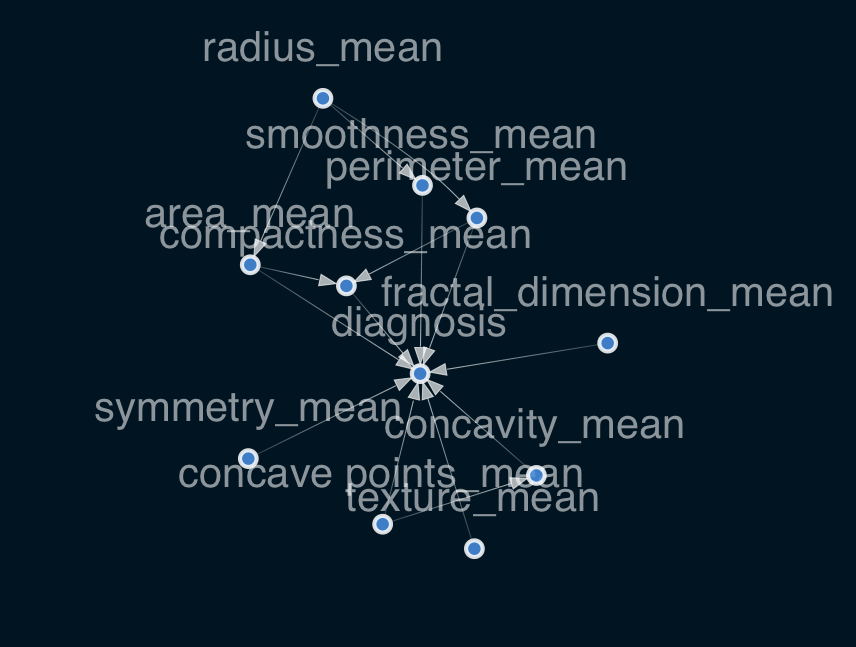

In [49]:
viz = plot_structure(
    sm,
    graph_attributes={"scale": "0.5"},
    all_node_attributes=NODE_STYLE.WEAK,
    all_edge_attributes=EDGE_STYLE.WEAK)
Image(viz.draw(format='png'))
